Note: you may need to restart the kernel to use updated packages.
Using device: cuda
Iteration 0/200 - Loss: 1.5620403289794922
Iteration 10/200 - Loss: 1.5177955627441406
Iteration 20/200 - Loss: 1.4726256132125854
Iteration 30/200 - Loss: 1.4263808727264404
Iteration 40/200 - Loss: 1.3791557550430298
Iteration 50/200 - Loss: 1.3310792446136475
Iteration 60/200 - Loss: 1.2822797298431396
Iteration 70/200 - Loss: 1.2328680753707886
Iteration 80/200 - Loss: 1.1828901767730713
Iteration 90/200 - Loss: 1.130890130996704
Iteration 100/200 - Loss: 1.0733444690704346
Iteration 110/200 - Loss: 1.0095711946487427
Iteration 120/200 - Loss: 0.9456508755683899
Iteration 130/200 - Loss: 0.880261242389679
Iteration 140/200 - Loss: 0.809208333492279
Iteration 150/200 - Loss: 0.7375869750976562
Iteration 160/200 - Loss: 0.6656637787818909
Iteration 170/200 - Loss: 0.5937480926513672
Iteration 180/200 - Loss: 0.5207566022872925
Iteration 190/200 - Loss: 0.4450201094150543


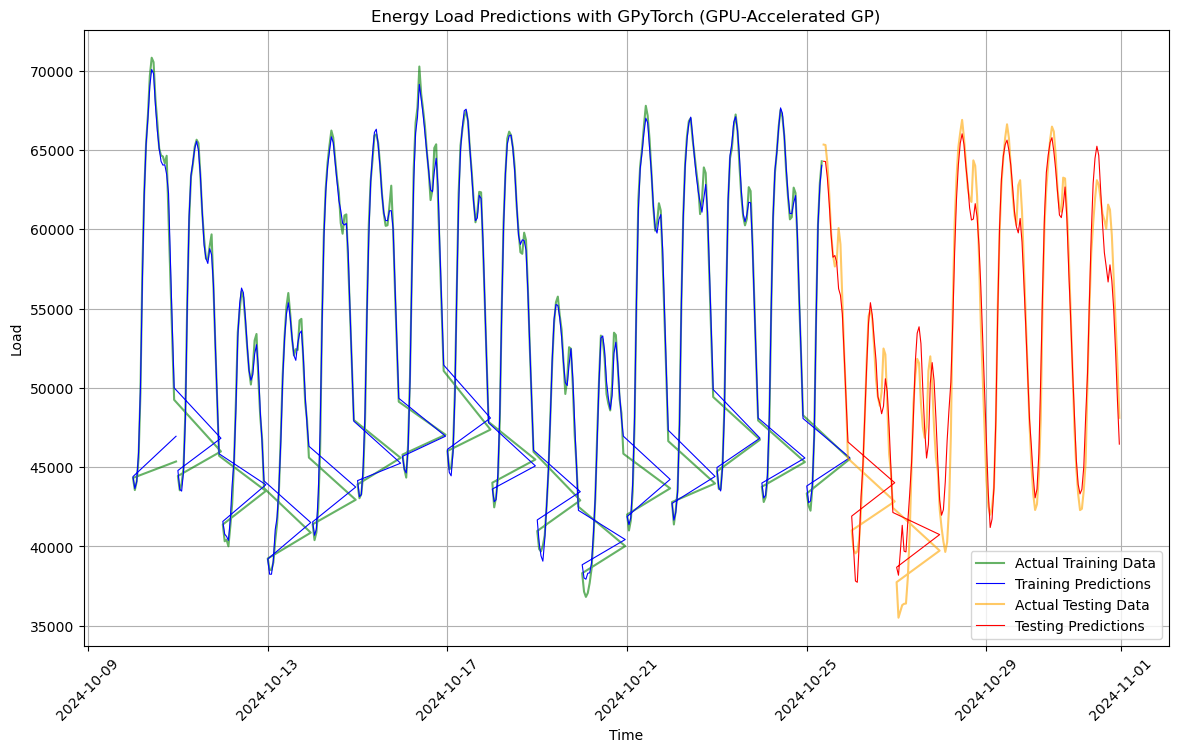

Training Mean Squared Error (MSE): 226626.07068840234
Training Mean Absolute Percentage Error (MAPE): 0.00686797997424615
Testing Mean Squared Error (MSE): 3475545.7149385656
Testing Mean Absolute Percentage Error (MAPE): 0.027958119800818273


In [ ]:
# The necessary libraries
%pip install torch gpytorch matplotlib pandas numpy scikit-learn
import torch
import gpytorch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the combined dataset
file_path = "./hourly_processed_data_with_features.csv"  
data = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)


# To ensure the 'time' column is properly converted to datetime
# data['time'] = pd.to_datetime(data['time'], format='%d-%m-%yT%H:%M:%S')  # Specify the datetime format

# To define the start and end dates
start_date = '10-10-2024 00:00:00'
end_date = '31-10-2024 23:00:00'

# To filter the data using boolean conditions
data = data[(data['time'] >= start_date) & (data['time'] <= end_date)]

# To ensure the 'time' column is properly converted to datetime and set as index
data.set_index('time', inplace=True)
data.index = pd.to_datetime(data.index, dayfirst=True)  # Specify dayfirst=True for d/m/y format


# Step 1: Feature Engineering
# To generate lagged features
for lag in range(1, 8):  # Create lags for the past 7 days
    data[f'load_lag_{lag}'] = data['load'].shift(lag)


# To split into training and testing sets (70% train, 30% test)
train_size = int(len(data) * 0.7)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# To separate features (X) and target (y)
features = [
    'load_lag_1', 'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6', 'load_lag_7',
    'price', 'temperature', 'day_of_week', 'month'
]
X_train = train_data[features]
y_train = train_data['load']
X_test = test_data[features]
y_test = test_data['load']

# To ensure no NaNs remain in training and testing data
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# To normalize the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_normalized = scaler_X.fit_transform(X_train)
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
X_test_normalized = scaler_X.transform(X_test)
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# To convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)

# To define GP model using GPyTorch
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() +
            gpytorch.kernels.PeriodicKernel(period_length=365) +  # Yearly periodicity
            gpytorch.kernels.PeriodicKernel(period_length=7) +    # Weekly periodicity
            gpytorch.kernels.MaternKernel(nu=1.5)                 # Flexible kernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# To define likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GPModel(X_train_tensor, y_train_tensor, likelihood).to(device)

# Step 3: Train the Model
model.train()
likelihood.train()

# Use Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)  # Adjusted learning rate

# To define marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# The training loop
training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    if i % 10 == 0:
        print(f"Iteration {i}/{training_iterations} - Loss: {loss.item()}")
    optimizer.step()

# Step 4: Evaluate the Model
model.eval()
likelihood.eval()

# To predict on training and testing data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_train_pred_normalized = likelihood(model(X_train_tensor)).mean.cpu().numpy()
    y_test_pred_normalized = likelihood(model(X_test_tensor)).mean.cpu().numpy()

# To rescale predictions back to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_normalized.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_normalized.reshape(-1, 1)).flatten()

# To rescale actual values back
y_train_actual = scaler_y.inverse_transform(y_train_normalized.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test_normalized.reshape(-1, 1)).flatten()

# To align dimensions of test data and predictions
if len(test_data.index) != len(y_test_actual):
    print(f"Adjusting dimensions: test_data.index={len(test_data.index)}, y_test_actual={len(y_test_actual)}")
    y_test_actual = y_test_actual[:len(test_data.index)]
    y_test_pred = y_test_pred[:len(test_data.index)]

# Step 5: Plot Results
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, y_train_actual, label="Actual Training Data", color="green", alpha=0.6)
plt.plot(train_data.index, y_train_pred, label="Training Predictions", color="blue", linewidth=0.8)
plt.plot(test_data.index, y_test_actual, label="Actual Testing Data", color="orange", alpha=0.6)
plt.plot(test_data.index, y_test_pred, label="Testing Predictions", color="red", linewidth=0.8)
plt.title("Energy Load Predictions with GPyTorch (GPU-Accelerated GP)")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Save the plot to a file
# plt.savefig('./energy_load_predictions_GP_model_3.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 6: Evaluate Performance
mse_train = mean_squared_error(y_train_actual, y_train_pred)
mse_test = mean_squared_error(y_test_actual, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("Training Mean Squared Error (MSE):", mse_train)
print("Training Mean Absolute Percentage Error (MAPE):", mape_train)
print("Testing Mean Squared Error (MSE):", mse_test)
print("Testing Mean Absolute Percentage Error (MAPE):", mape_test)